In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# for the minimising function
from scipy.optimize import minimize

# for reading MATLAB files
from scipy.io import loadmat

In [31]:
# alternative minimize function
import scipy.optimize as opt 

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
# Neural Network model

# 3 layers - input, hidden and output

# input layer X has 401 neurons 
# hidden layer has 25 neurons
# output layer has 10 neuros
# input layer a1 is X with intercept - (5000,401)

# weights between input layer and hidden layer = Theta1 - (25,401)
# weights between hidden layer and output layer = Theta2 - (10,26)

# z2 = Theta1 x a1
# a2 = g(z2) plus intercept
# z3 = Theta2 x a2
# a3 = g(z3) = htheta(x)


In [38]:
# read X, y data from file 

path = "D:\Programming\TestData\ex4data1.mat"
#same data as in ex3data1.mat

data = loadmat(path)
#loads X, y from MATLAB file ex3data1.mat
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [39]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [40]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

In [41]:
#extract X, y
X, y = data['X'], data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

In [42]:
# unique class labels in y
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [43]:
# read weights data from file 

path = "D:\Programming\TestData\ex4weights.mat"
#same as in ex3weights.mat

weights = loadmat(path)
#loads X, y from MATLAB file ex3data1.mat
#weights

In [44]:
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [45]:
# extract Theta1, Theta2
Theta1, Theta2 = weights['Theta1'], weights['Theta2'] 

print('Theta1: {}'.format(Theta1.shape))
print('Theta2: {}'.format(Theta2.shape))

Theta1: (25, 401)
Theta2: (10, 26)


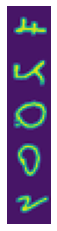

In [46]:
sample = np.random.choice(X.shape[0], 5)
# pick 5 rows in X at random

plt.imshow(X[sample].reshape(-1,20))
plt.axis('off');
# note semicolon above

In [47]:
# convert y (5000,1) to yOneHot (5000,10)
# each row of yOneHot has all zeros except for the element corresponsing to label
# i.e. if y[25] = 7, then yOneHot[25] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] (i.e. 1 in 7th element of row 25)

#encoder = OneHotEncoder(sparse = False)
#yOneHot = encoder.fit_transform(y)

# move this to within cost function
# cost function needs parameter 'y' not 'yOneHot'; create 'yOneHot' from 'y' inside cost function

In [48]:
#y[4000], yOneHot[4000]

In [49]:
# sigmoid
# hypothesie
# for the feed forward computation

def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [50]:
# sigmoid gradient
# for the back propagation computation

def sigmoidGradient(z):
    return sigmoid(z) * (1-sigmoid(z))

In [51]:
# testing sigmoidGradient
z= 0
sigmoidGradient(z)

0.25

In [52]:
# random intitialing weights
# the initial weights for back prop should not be set to 0, to avoid getting stuck in symmetric calculations 
# i.e break symmetry during training / minimizing / learning actual weights
# instead set them randomly so that calculations can proceed further

def randomInitialize(linesIn, linesOut):
    
    epsilon = ((6)**0.5) / ((linesIn + linesOut) ** 0.5)
    # see ex4 pdf note
        
    W = np.random.random((linesOut, linesIn + 1))
    
    # normalize so that it spans a range of twice epsilon
    W = W * 2 * epsilon
    
    # shift so that mean is at 0
    W = W - epsilon
        
    return W 

In [53]:
initialTheta1 = randomInitialize(400, 25)
initialTheta2 = randomInitialize(25, 10)

In [54]:
print(initialTheta1.shape)
print(initialTheta2.shape)

(25, 401)
(10, 26)


In [55]:
def forwardPass(X, Theta1, Theta2):    

    # add intercept at input layer
    a1 = np.c_[np.ones((X.shape[0], 1)), X] # (5000,401)    
    
    z2 = np.dot(a1, Theta1.T) # (5000,401) * (401,25) ->(5000,25)
    a2 = sigmoid(z2)
    
    # add intercept at hidden layer
    a2 = np.c_[np.ones((a2.shape[0], 1)), a2] # (5000,26)    
    
    z3 = np.dot(a2, Theta2.T) # (5000,26) * (26,10) ->(5000,10)
    a3 = sigmoid(z3)
    
    return a1, z2, a2, z3, a3

In [56]:
def nnCostFunction(nnParams, inputLayerSize, hiddenLayerSize, numLabels, X, y, learningRate):
    """
    X is (5000,400)
    yOneHot is (5000,10)
    
    Theta1 is (25,401)
    Theta2 is (10,26)
    
    z2 = Theta1 x a1
    a2 = g(z2) plus intercept
    z3 = Theta2 x a2
    a3 = g(z3) = htheta(x)
    
    """
    m = X.shape[0]

    # convert y (5000,1) to yOneHot (5000,10)
    # each row of yOneHot has all zeros except for the element corresponsing to label
    # i.e. if y[25] = 7, then yOneHot[25] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] (i.e. 1 in 7th element of row 25)
    encoder = OneHotEncoder(sparse = False)
    yOneHot = encoder.fit_transform(y)
    
    
    # return cost, from forward pass
    cost = 0

    # cost (forward pass)
    # ==================
   
    # extract Theta1,Theta2 from nnParams
    Theta1 = nnParams[0 : (hiddenLayerSize * (inputLayerSize + 1))].reshape(hiddenLayerSize, (inputLayerSize + 1))
    Theta2 = nnParams[(hiddenLayerSize * (inputLayerSize + 1)) :  ].reshape(numLabels,       (hiddenLayerSize + 1))    
   

    a1,z2,a2,z3,a3 = forwardPass(X, Theta1, Theta2)    
    """
    # add intercept at input layer
    a1 = np.c_[np.ones((X.shape[0], 1)), X] # (5000,401)    
    
    z2 = np.dot(a1, Theta1.T) # (5000,401) * (401,25) ->(5000,25)
    a2 = sigmoid(z2)
    
    # add intercept at hidden layer
    a2 = np.c_[np.ones((a2.shape[0], 1)), a2] # (5000,26)    
    
    z3 = np.dot(a2, Theta2.T) # (5000,26) * (26,10) ->(5000,10)
    a3 = sigmoid(z3)
    """
    
    # calculating regularization term
    regTerm = (learningRate/(2*m)) * (np.sum(np.square(Theta1[:,1:])) + np.sum(np.square(Theta2[:,1:])))
    # ignoring intercept first column of theta which is not regularized

    term1 = np.multiply(-yOneHot, np.log(a3)) 
    term2 = np.multiply((1-yOneHot), np.log(1 - a3))
    # note difference between numpy.dot and numpy.multiply
    # numpy.dot is dot product of matrices
    # numpy.multiply is elementwise multiplication
    
    cost = (1/m) * np.sum(term1 - term2) + regTerm
    
    
    # back propagation
    # ==================
    
    # return gradients, from back pass
    Theta1Grad = np.zeros((Theta1.size))
    Theta2Grad = np.zeros((Theta2.size))
    
    #computing errors at every node of every layer
    
    d3 = a3 - yOneHot 
    # each being (5000,10)
    
    d2 = np.multiply(np.dot(d3, Theta2[:,1:]), sigmoidGradient(z2))
    # d3 is (5000,10), Theta2[:,1:] is (10,25), hence dot product is (5000,25)
    # z2 is (5000,25), hence elementwise product d2 is (5000,25)
    
    delta2 = np.dot(d3.T, a2)
    # d3 is (10,5000), a2 is (5000,26), 
    # result delta2 is (10,26) - same as Theta1
    
    delta1 = np.dot(d2.T, a1)
    # d2 is (25,5000), a1 is (5000,401)
    # result delta1 is (25,401) - same as Theta2

    #regularizing gradients
    
    # intercept term is not regularized, first column set to zero
    Theta1[:, 0] = 0 
    Theta2[:, 0] = 0    
    
    # here shape of theta is retained since end result grad is shape of Theta    
    Theta1Grad = (delta1 / m ) + (learningRate / m) * Theta1
    Theta2Grad = (delta2 / m ) + (learningRate / m) * Theta2    
   
    #unroll into vectors
    grads = np.r_[Theta1Grad.ravel(), Theta2Grad.ravel()]
    
    return cost, grads

In [57]:
inputLayerSize = 400 
hiddenLayerSize = 25 
numLabels = 10


In [60]:
# Unroll parameters.
nnParams = np.r_[Theta1.ravel(), Theta2.ravel()]

In [59]:
# testing cost with regularization
learningRate = 0

cost, grad = nnCostFunction(nnParams, inputLayerSize, hiddenLayerSize, numLabels, X, y, learningRate)
cost

0.2876291651613189

In [61]:
# testing cost with regularization
learningRate = 1

cost, grad = nnCostFunction(nnParams, inputLayerSize, hiddenLayerSize, numLabels, X, y, learningRate)
cost

0.38376985909092365

In [62]:
# minimize the objective function
fmin = minimize(fun = nnCostFunction, x0 = nnParams, args = (inputLayerSize, hiddenLayerSize, numLabels, X, y, learningRate), 
                method='TNC', jac = True, options = {'maxiter': 250})
fmin

     fun: 0.337383568160693
     jac: array([-1.35698818e-04, -1.73743231e-12,  3.60919462e-13, ...,
       -3.42475249e-05,  2.38841116e-05, -5.99301385e-05])
 message: 'Linear search failed'
    nfev: 125
     nit: 4
  status: 4
 success: False
       x: array([-7.65112229e-02, -8.68716153e-09,  1.80459731e-09, ...,
       -3.57018124e-01,  1.84608277e+00, -1.82264364e+00])

In [63]:
# alternative

In [64]:
fmin = opt.fmin_tnc(func = nnCostFunction, x0 = nnParams, args = (inputLayerSize, hiddenLayerSize, numLabels, X, y, learningRate))

parameters = fmin[0]

In [65]:
parameters

array([-7.65112229e-02, -8.68716153e-09,  1.80459731e-09, ...,
       -3.57018124e-01,  1.84608277e+00, -1.82264364e+00])

In [66]:
optTheta1 = parameters[0 : (hiddenLayerSize * (inputLayerSize + 1))].reshape(hiddenLayerSize, (inputLayerSize + 1))
optTheta2 = parameters[(hiddenLayerSize * (inputLayerSize + 1)) :  ].reshape(numLabels,       (hiddenLayerSize + 1)) 

optTheta1.shape, optTheta2.shape

((25, 401), (10, 26))

In [67]:
a1,z2,a2,z3,a3 = forwardPass(X, optTheta1, optTheta2) 

In [68]:
# create array of the index with the maximum probability
hArgmax = np.argmax(a3, axis=1)

In [70]:
print('Training set accuracy: {} %'.format(np.mean(hArgmax == y.ravel())*100))

Training set accuracy: 0.04 %
